In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
!pip install bayesian-optimization

In [3]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv1D, Flatten
import tensorflow as tf
import numpy as np
import os
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from sklearn.preprocessing import OneHotEncoder

from bayes_opt import BayesianOptimization

In [4]:
train=pd.read_csv("./train_data.csv", encoding='cp949')
test=pd.read_csv("./test_data.csv", encoding='cp949')

## 전처리

In [5]:
#결측치 확인
def shownull(df):
    global missval_name
    print(f"데이터셋 차원 확인 \n {df.shape}")
    missval = df.isnull().sum()[df.isnull().sum()!=0]
    print(f"결측값 있는 변수 확인 \n {missval}")
    missval_name = missval.index # 결측치가 존재하는 열이 저장된 변수

#이상치 확인
def zscore_out(df, threshold = 3):
    mean = np.mean(df)
    std = np.std(df)
    z_score = np.abs((df - df.mean()) / df.std())
    outliers = np.where(z_score > threshold)
    # outlier_idx = outliers.nonzero()[0]
    print(outliers[0])

#시드고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(84)

In [6]:
train
#regdate에 대해 요일, 시간

,regdate,temp,humi,co2,dust_pm1,dust_pm_25,dust_pm_10,illuminance,voc,eco2,PIR,재실인원
0,2023-01-01 0:00,21.2,34.0,414.0,14.0,14.0,14.0,0.0,2535.0,2845.0,0.0,1
1,2023-01-01 0:01,21.2,34.0,411.0,13.0,13.0,13.0,0.0,2535.0,2845.0,0.0,1
2,2023-01-01 0:02,21.2,34.0,409.0,14.0,14.0,14.0,0.0,2535.0,2845.0,0.0,1
3,2023-01-01 0:03,21.2,34.0,409.0,14.0,14.0,14.0,0.0,2500.0,2829.0,0.0,1
4,2023-01-01 0:04,21.2,34.0,415.0,14.0,14.0,14.0,0.0,2500.0,2829.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
388795,2023-01-27 23:55,17.4,17.0,414.0,9.0,9.0,9.0,1.0,7.0,452.0,0.0,0
388796,2023-01-27 23:56,17.4,17.0,410.0,9.0,9.0,9.0,1.0,7.0,452.0,0.0,0
388797,2023-01-27 23:57,17.4,17.0,417.0,9.0,9.0,9.0,1.0,7.0,452.0,0.0,0
388798,2023-01-27 23:58,17.5,17.0,414.0,9.0,9.0,9.0,1.0,8.0,455.0,0.0,0


### 결측치 대체

In [7]:
shownull(train)
#레이블은 빈거 없음
#regdate는 바로 위의 인스턴스에서 1초 더하면 될거같음
#나머지는 중위값으로 대체
shownull(test)

데이터셋 차원 확인 
 (388800, 12)
결측값 있는 변수 확인 
 regdate        13799
temp           78058
humi           78058
co2            78058
dust_pm1       78058
dust_pm_25     78058
dust_pm_10     78058
illuminance    78058
voc            78058
eco2           78058
PIR            78058
dtype: int64
데이터셋 차원 확인 
 (85000, 12)
결측값 있는 변수 확인 
 temp           80
humi           80
co2            80
dust_pm1       80
dust_pm_25     80
dust_pm_10     80
illuminance    80
voc            80
eco2           80
PIR            80
dtype: int64


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388800 entries, 0 to 388799
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   regdate      375001 non-null  object 
 1   temp         310742 non-null  float64
 2   humi         310742 non-null  float64
 3   co2          310742 non-null  float64
 4   dust_pm1     310742 non-null  float64
 5   dust_pm_25   310742 non-null  float64
 6   dust_pm_10   310742 non-null  float64
 7   illuminance  310742 non-null  float64
 8   voc          310742 non-null  float64
 9   eco2         310742 non-null  float64
 10  PIR          310742 non-null  float64
 11  재실인원         388800 non-null  int64  
dtypes: float64(10), int64(1), object(1)
memory usage: 35.6+ MB


In [9]:
# Train set에 대해서 시간 변수 결측치 대체

train['regdate'] = pd.to_datetime(train['regdate'])

# 시작일과 종료일 설정
start_date = train['regdate'].min()  # 시작일: 2023-01-01 00:00
end_date = train['regdate'].max()  # 종료일: 2023-01-27 23:59    -------> min, max를 이용해서 data leakage 문제를 해결

# 결측치를 수정하고 이전 시간으로부터 순서대로 채워넣음
current_date = start_date  # 현재 날짜 초기화

for i in range(len(train)):
    # 결측치인 경우 이전 시간으로 대체
    if pd.isnull(train.loc[i, 'regdate']):
        train.loc[i, 'regdate'] = current_date
    
    # 다음 시간으로 이동
    current_date += timedelta(minutes=1)
    
    # 종료일인 경우 시작일로 되돌아감
    if current_date > end_date:
        current_date = start_date

#제대로 작동됨

In [10]:
# Test set에 대해서 시간 변수 결측치 대체

test['regdate'] = pd.to_datetime(test['regdate'])

# 시작일과 종료일 설정
start_date = test['regdate'].min()  # 시작일: 2023-01-01 00:00
end_date = test['regdate'].max()  # 종료일: 2023-01-27 23:59    -------> min, max를 이용해서 data leakage 문제를 해결

# 결측치를 수정하고 이전 시간으로부터 순서대로 채워넣음
current_date = start_date  # 현재 날짜 초기화

for i in range(len(test)):
    # 결측치인 경우 이전 시간으로 대체
    if pd.isnull(test.loc[i, 'regdate']):
        test.loc[i, 'regdate'] = current_date
    
    # 다음 시간으로 이동
    current_date += timedelta(minutes=1)
    
    # 종료일인 경우 시작일로 되돌아감
    if current_date > end_date:
        current_date = start_date

### 독립변수 추가

In [11]:
# TRAIN 요일 변수 추가
daysofweek = []
for i in range(len(train)) :
    dayweek = train.loc[i, 'regdate'].dayofweek
    daysofweek.append(dayweek)

train['dayofweek'] = daysofweek



#월요일 0 ~ 일요일6

<!--  -->

In [12]:
# TEST 요일 변수 추가

daysofweek = []
for i in range(len(test)) :
    dayweek = test.loc[i, 'regdate'].dayofweek
    daysofweek.append(dayweek)

test['dayofweek'] = daysofweek

In [13]:
# TRAIN 시간 -> 10진법 변환
train['time'] = train['regdate'].dt.strftime('%H:%M').str.split().str[0]
train['time'] = train['time'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

In [14]:
# TEST 시간 -> 10진법 변환
test['time'] = test['regdate'].dt.strftime('%H:%M').str.split().str[0]
test['time'] = test['time'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

In [15]:
it_is_not_na = np.where(~train[['PIR']].isnull())[0]

train.loc[it_is_not_na,['PIR']] = train.loc[it_is_not_na,['PIR']].astype(np.int64)

### 결측치 대체

In [16]:
# def cat_num_na(df) :

#     #변수 타입별로 분리
#     cat_na = df.select_dtypes(include=['object', 'int64'])
#     num_na = df.select_dtypes(include=['float64'])

#     #범주형 변수 최빈값으로 변환
#     for col in cat_na:
#         df[col].fillna(df[col].mode()[0], inplace=True)

#     #수치형 변수 중위값 대체
#     for col2 in num_na:
#         df[col2].fillna(df[col2].median(), inplace=True)

In [17]:
def make_area(df) :
    # 입력된 날짜 변수의 차이 계산
    date_range = df['regdate'].max() - df['regdate'].min()

    # 간격당 행의 개수 계산
    lowsbydate = ((date_range.days + 1) * 1440) #하루 1440분
    group_num = len(train) / lowsbydate

    for i in range(int(group_num)):
        start_index = i * lowsbydate
        end_index = (i + 1) * lowsbydate
        df.loc[start_index : end_index, 'area'] = i + 1

# def inter_by_area(df):
#     df.update(df.groupby('area').transform(lambda x: x.interpolate(method = 'pad')))
#     return df

In [18]:
shownull(train)

데이터셋 차원 확인 
 (388800, 14)
결측값 있는 변수 확인 
 temp           78058
humi           78058
co2            78058
dust_pm1       78058
dust_pm_25     78058
dust_pm_10     78058
illuminance    78058
voc            78058
eco2           78058
PIR            78058
dtype: int64


In [19]:
train

,regdate,temp,humi,co2,dust_pm1,dust_pm_25,dust_pm_10,illuminance,voc,eco2,PIR,재실인원,dayofweek,time
0,2023-01-01 00:00:00,21.2,34.0,414.0,14.0,14.0,14.0,0.0,2535.0,2845.0,0.0,1,6,0
1,2023-01-01 00:01:00,21.2,34.0,411.0,13.0,13.0,13.0,0.0,2535.0,2845.0,0.0,1,6,1
2,2023-01-01 00:02:00,21.2,34.0,409.0,14.0,14.0,14.0,0.0,2535.0,2845.0,0.0,1,6,2
3,2023-01-01 00:03:00,21.2,34.0,409.0,14.0,14.0,14.0,0.0,2500.0,2829.0,0.0,1,6,3
4,2023-01-01 00:04:00,21.2,34.0,415.0,14.0,14.0,14.0,0.0,2500.0,2829.0,0.0,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388795,2023-01-27 23:55:00,17.4,17.0,414.0,9.0,9.0,9.0,1.0,7.0,452.0,0.0,0,4,1435
388796,2023-01-27 23:56:00,17.4,17.0,410.0,9.0,9.0,9.0,1.0,7.0,452.0,0.0,0,4,1436
388797,2023-01-27 23:57:00,17.4,17.0,417.0,9.0,9.0,9.0,1.0,7.0,452.0,0.0,0,4,1437
388798,2023-01-27 23:58:00,17.5,17.0,414.0,9.0,9.0,9.0,1.0,8.0,455.0,0.0,0,4,1438


In [20]:
train_nona = train.copy()
# cat_num_na(train_nona)
make_area(train_nona)

test_nona = test.copy()
# cat_num_na(test_nona)
make_area(test_nona)

In [21]:
def replace_missing_with_mean(dataframe, dependent_col, independent_cols):
    for col in independent_cols:
        mean = dataframe.groupby(dependent_col)[col].transform('mean')
        dataframe[col].fillna(mean, inplace=True)

In [22]:
# 결측 값 대체
f_list=['temp','humi','co2','dust_pm1','dust_pm_25','dust_pm_10','illuminance','voc','eco2','PIR']
replace_missing_with_mean(train_nona, 'area', f_list )
replace_missing_with_mean(test_nona, 'area', f_list )

In [23]:
shownull(train_nona)
shownull(test_nona)

데이터셋 차원 확인 
 (388800, 15)
결측값 있는 변수 확인 
 Series([], dtype: int64)
데이터셋 차원 확인 
 (85000, 15)
결측값 있는 변수 확인 
 Series([], dtype: int64)


### 파일 분할 및 스케일링

In [24]:
#One-Hot Encoding
# ohe = OneHotEncoder(sparse=False)
# onehot_train = ohe.fit_transform(train_nona[['dayofweek']])
# onehot_test = ohe.transform(test_nona[['dayofweek']])

# onehot_train2 = pd.DataFrame(onehot_train, columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# onehot_test2 = pd.DataFrame(onehot_test, columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# onehot_train3 = pd.concat([train_nona.drop('dayofweek', axis=1), onehot_train2], axis=1)
# onehot_test3 = pd.concat([test_nona.drop('dayofweek', axis=1), onehot_test2], axis=1)

In [25]:
X_train = train_nona.drop('재실인원', axis=1)
y_train = train_nona['재실인원']

X_test = test_nona.drop('재실인원', axis=1)
y_test = test_nona['재실인원']

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [27]:
#regdate 제거한 뒤 확인

X_train = X_train.drop(['regdate','area','dayofweek'], axis=1)
X_valid = X_valid.drop(['regdate','area','dayofweek'], axis=1)
X_test = X_test.drop(['regdate','area','dayofweek'], axis=1)

In [28]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [29]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [30]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10
0,0.547595,0.305575,0.187834,0.005564,0.003774,0.001962,0.028112,0.000691,0.009025,0.006605,0.774844
1,0.450382,0.486842,0.172163,0.001449,0.000980,0.000504,0.000000,0.000519,0.006982,0.000000,0.120222
2,0.547595,0.305575,0.187834,0.005564,0.003774,0.001962,0.028112,0.000691,0.009025,0.006605,0.370396
3,0.450279,0.306361,0.206783,0.018542,0.012562,0.006551,0.043305,0.001440,0.015706,0.000977,0.209173
4,0.816794,0.144737,0.349893,0.002899,0.001961,0.001009,0.050360,0.001266,0.016838,0.000000,0.072967
...,...,...,...,...,...,...,...,...,...,...,...
291595,0.549618,0.263158,0.244540,0.015942,0.010784,0.006051,0.021583,0.000504,0.006797,0.000000,0.985407
291596,0.641221,0.210526,0.166595,0.040580,0.027451,0.014120,0.057554,0.000549,0.007446,0.000000,0.054204
291597,0.603053,0.263158,0.284797,0.034783,0.023529,0.012103,0.021583,0.002472,0.032903,0.000000,0.619875
291598,0.709924,0.131579,0.253961,0.007246,0.004902,0.002521,0.079137,0.000732,0.009794,0.000000,0.991661


In [31]:
X_train = np.reshape(X_train, (len(X_train),11,1)).astype(float)
X_valid = np.reshape(X_valid, (len(X_valid),11,1)).astype(float)
X_test = np.reshape(X_test, (len(X_test),11,1)).astype(float)

In [32]:
X_train.shape

(291600, 11, 1)

## 모델 설정

In [33]:
mse =[]
def buildModel(neurons,drop,nb_batch,hidden_layers):  
    nb_epoch=5
    neurons=int(neurons)
    hidden_layers=int(hidden_layers)

    # input layer
    inputs = tf.keras.Input(shape=(11,1))
    x = tf.keras.layers.Conv1D(11,10, activation='relu')(inputs)
    x = tf.keras.layers.Flatten()(x)

    if hidden_layers !=0:
        for i in range(1,hidden_layers+1):
            x = tf.keras.layers.Dense(neurons*(2**(hidden_layers+1)), activation='relu')(x)
    x = tf.keras.layers.Dense(neurons*(2**(hidden_layers+1)),activation='relu')(x)
    x = tf.keras.layers.Dropout(drop)(x)

    # output
    predictions = Dense(1)(x)


    # modeling
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode="min",patience=3,restore_best_weights=True, verbose=1)



    # learning
    model.fit(X_train, y_train, epochs=int(nb_epoch), batch_size=int(nb_batch),callbacks=[early_stopping], validation_data=(X_valid, y_valid))


    # evaluate the model with test data
    loss, mse = model.evaluate(X_test, y_test)
    
    if mse < 1.0: 
        model.save(f"./model/cnn/{mse}_cnn.h5")
        print("모델이 저장 되었습니다.")
        print("loss : ",loss)
        print("mse : ",mse)
    
    return mse

In [34]:
pbounds = {
        # define the range of each parameter
        'drop' : (0.5,0.9),
        "neurons" : (12,24),
        'nb_batch' : (512,1024),
        'hidden_layers' : (0,3)}

In [35]:
bo=BayesianOptimization(f=buildModel, pbounds=pbounds, verbose=2, random_state=42 )

## 학습

In [36]:
bo.maximize(
   init_points=2,
   n_iter=100
)

|   iter    |  target   |   drop    | hidden... | nb_batch  |  neurons  |
-------------------------------------------------------------------------
Epoch 1/5
330/330 [==============================] - 5s 7ms/step - loss: 1.1316 - mean_squared_error: 1.1316 - val_loss: 0.7247 - val_mean_squared_error: 0.7247
Epoch 2/5
330/330 [==============================] - 2s 6ms/step - loss: 0.7656 - mean_squared_error: 0.7656 - val_loss: 0.6431 - val_mean_squared_error: 0.6431
Epoch 3/5
330/330 [==============================] - 2s 7ms/step - loss: 0.6903 - mean_squared_error: 0.6903 - val_loss: 0.6156 - val_mean_squared_error: 0.6156
Epoch 4/5
330/330 [==============================] - 2s 7ms/step - loss: 0.6314 - mean_squared_error: 0.6314 - val_loss: 0.6072 - val_mean_squared_error: 0.6072
Epoch 5/5
2657/2657 [==============================] - 9s 3ms/step - loss: 73.9305 - mean_squared_error: 73.9305
| 1         | 73.93     | 0.6498    | 2.852     | 886.8     | 19.18     |
Epoch 1/5
540/540 [==

2657/2657 [==============================] - 9s 3ms/step - loss: 321.2457 - mean_squared_error: 321.2457
| 8         | 321.2     | 0.8753    | 2.119     | 742.5     | 23.98     |
Epoch 1/5
394/394 [==============================] - 4s 9ms/step - loss: 1.1126 - mean_squared_error: 1.1126 - val_loss: 0.7116 - val_mean_squared_error: 0.7116
Epoch 2/5
394/394 [==============================] - 3s 7ms/step - loss: 0.7842 - mean_squared_error: 0.7842 - val_loss: 0.6234 - val_mean_squared_error: 0.6234
Epoch 3/5
394/394 [==============================] - 3s 7ms/step - loss: 0.7017 - mean_squared_error: 0.7017 - val_loss: 0.5545 - val_mean_squared_error: 0.5545
Epoch 4/5
394/394 [==============================] - 3s 7ms/step - loss: 0.6204 - mean_squared_error: 0.6204 - val_loss: 0.4880 - val_mean_squared_error: 0.4880
Epoch 5/5
2657/2657 [==============================] - 9s 3ms/step - loss: 225.8611 - mean_squared_error: 225.8611
| 9         | 225.9     | 0.7825    | 2.345     | 741.5     | 

Epoch 5/5
2657/2657 [==============================] - 8s 3ms/step - loss: 44.3732 - mean_squared_error: 44.3732
| 24        | 44.37     | 0.5234    | 0.3865    | 793.8     | 22.44     |
Epoch 1/5
488/488 [==============================] - 4s 6ms/step - loss: 1.5115 - mean_squared_error: 1.5115 - val_loss: 0.8426 - val_mean_squared_error: 0.8426
Epoch 2/5
488/488 [==============================] - 3s 6ms/step - loss: 1.0980 - mean_squared_error: 1.0980 - val_loss: 0.7835 - val_mean_squared_error: 0.7835
Epoch 3/5
488/488 [==============================] - 3s 6ms/step - loss: 1.0329 - mean_squared_error: 1.0329 - val_loss: 0.7531 - val_mean_squared_error: 0.7531
Epoch 4/5
488/488 [==============================] - 3s 7ms/step - loss: 1.0003 - mean_squared_error: 1.0003 - val_loss: 0.7076 - val_mean_squared_error: 0.7076
Epoch 5/5
2657/2657 [==============================] - 8s 3ms/step - loss: 7.0094 - mean_squared_error: 7.0094
| 25        | 7.009     | 0.879     | 1.811     | 598.4   

Epoch 4/5
393/393 [==============================] - 3s 7ms/step - loss: 0.8638 - mean_squared_error: 0.8638 - val_loss: 0.6506 - val_mean_squared_error: 0.6506
Epoch 5/5
2657/2657 [==============================] - 8s 3ms/step - loss: 24.9175 - mean_squared_error: 24.9175
| 40        | 24.92     | 0.8497    | 1.832     | 743.2     | 23.74     |
Epoch 1/5
440/440 [==============================] - 3s 7ms/step - loss: 1.2510 - mean_squared_error: 1.2510 - val_loss: 0.7359 - val_mean_squared_error: 0.7359
Epoch 2/5
440/440 [==============================] - 3s 6ms/step - loss: 0.8099 - mean_squared_error: 0.8099 - val_loss: 0.6751 - val_mean_squared_error: 0.6751
Epoch 3/5
440/440 [==============================] - 3s 7ms/step - loss: 0.7616 - mean_squared_error: 0.7616 - val_loss: 0.6491 - val_mean_squared_error: 0.6491
Epoch 4/5
440/440 [==============================] - 3s 7ms/step - loss: 0.7248 - mean_squared_error: 0.7248 - val_loss: 0.6241 - val_mean_squared_error: 0.6241
Epoch 5/

Epoch 4/5
333/333 [==============================] - 2s 7ms/step - loss: 0.6500 - mean_squared_error: 0.6500 - val_loss: 0.5368 - val_mean_squared_error: 0.5368
Epoch 5/5
2657/2657 [==============================] - 9s 3ms/step - loss: 411.2324 - mean_squared_error: 411.2324
| 48        | 411.2     | 0.6561    | 2.531     | 877.0     | 16.83     |
Epoch 1/5
346/346 [==============================] - 3s 7ms/step - loss: 1.1314 - mean_squared_error: 1.1314 - val_loss: 0.6936 - val_mean_squared_error: 0.6936
Epoch 2/5
346/346 [==============================] - 2s 7ms/step - loss: 0.7740 - mean_squared_error: 0.7740 - val_loss: 0.6230 - val_mean_squared_error: 0.6230
Epoch 3/5
346/346 [==============================] - 2s 7ms/step - loss: 0.7002 - mean_squared_error: 0.7002 - val_loss: 0.5664 - val_mean_squared_error: 0.5664
Epoch 4/5
346/346 [==============================] - 2s 6ms/step - loss: 0.6464 - mean_squared_error: 0.6464 - val_loss: 0.5127 - val_mean_squared_error: 0.5127
Epoch 

Epoch 3/5
394/394 [==============================] - 2s 6ms/step - loss: 1.7007 - mean_squared_error: 1.7007 - val_loss: 1.2511 - val_mean_squared_error: 1.2511
Epoch 4/5
394/394 [==============================] - 2s 6ms/step - loss: 1.5505 - mean_squared_error: 1.5505 - val_loss: 1.1659 - val_mean_squared_error: 1.1659
Epoch 5/5
2657/2657 [==============================] - 8s 3ms/step - loss: 7.1012 - mean_squared_error: 7.1012
| 64        | 7.101     | 0.8984    | 0.4427    | 741.5     | 13.54     |
Epoch 1/5
334/334 [==============================] - 2s 5ms/step - loss: 2.3006 - mean_squared_error: 2.3006 - val_loss: 1.3625 - val_mean_squared_error: 1.3625
Epoch 2/5
334/334 [==============================] - 2s 6ms/step - loss: 1.6173 - mean_squared_error: 1.6173 - val_loss: 1.0954 - val_mean_squared_error: 1.0954
Epoch 3/5
334/334 [==============================] - 2s 6ms/step - loss: 1.4004 - mean_squared_error: 1.4004 - val_loss: 0.9852 - val_mean_squared_error: 0.9852
Epoch 4/5


Epoch 3/5
353/353 [==============================] - 2s 6ms/step - loss: 1.4241 - mean_squared_error: 1.4241 - val_loss: 0.9981 - val_mean_squared_error: 0.9981
Epoch 4/5
353/353 [==============================] - 2s 6ms/step - loss: 1.3292 - mean_squared_error: 1.3292 - val_loss: 0.9559 - val_mean_squared_error: 0.9559
Epoch 5/5
2657/2657 [==============================] - 8s 3ms/step - loss: 2.8530 - mean_squared_error: 2.8530
| 72        | 2.853     | 0.8663    | 0.7565    | 827.4     | 14.26     |
Epoch 1/5
354/354 [==============================] - 3s 6ms/step - loss: 1.6943 - mean_squared_error: 1.6943 - val_loss: 0.9638 - val_mean_squared_error: 0.9638
Epoch 2/5
354/354 [==============================] - 2s 5ms/step - loss: 1.0553 - mean_squared_error: 1.0553 - val_loss: 0.8398 - val_mean_squared_error: 0.8398
Epoch 3/5
354/354 [==============================] - 2s 6ms/step - loss: 0.9508 - mean_squared_error: 0.9508 - val_loss: 0.7830 - val_mean_squared_error: 0.7830
Epoch 4/5


Epoch 3/5
424/424 [==============================] - 3s 7ms/step - loss: 0.7913 - mean_squared_error: 0.7913 - val_loss: 0.6791 - val_mean_squared_error: 0.6791
Epoch 4/5
424/424 [==============================] - 3s 7ms/step - loss: 0.7579 - mean_squared_error: 0.7579 - val_loss: 0.6659 - val_mean_squared_error: 0.6659
Epoch 5/5
2657/2657 [==============================] - 9s 3ms/step - loss: 22.4017 - mean_squared_error: 22.4017
| 80        | 22.4      | 0.5222    | 1.604     | 688.5     | 15.19     |
Epoch 1/5
291/291 [==============================] - 3s 7ms/step - loss: 1.7638 - mean_squared_error: 1.7638 - val_loss: 0.9073 - val_mean_squared_error: 0.9073
Epoch 2/5
291/291 [==============================] - 2s 5ms/step - loss: 1.1615 - mean_squared_error: 1.1615 - val_loss: 0.8042 - val_mean_squared_error: 0.8042
Epoch 3/5
291/291 [==============================] - 2s 7ms/step - loss: 1.0544 - mean_squared_error: 1.0544 - val_loss: 0.7733 - val_mean_squared_error: 0.7733
Epoch 4/

Epoch 2/5
291/291 [==============================] - 2s 7ms/step - loss: 0.7716 - mean_squared_error: 0.7716 - val_loss: 0.6580 - val_mean_squared_error: 0.6580
Epoch 3/5
291/291 [==============================] - 2s 7ms/step - loss: 0.7286 - mean_squared_error: 0.7286 - val_loss: 0.6093 - val_mean_squared_error: 0.6093
Epoch 4/5
291/291 [==============================] - 2s 7ms/step - loss: 0.6801 - mean_squared_error: 0.6801 - val_loss: 0.5726 - val_mean_squared_error: 0.5726
Epoch 5/5
2657/2657 [==============================] - 9s 3ms/step - loss: 121.0873 - mean_squared_error: 121.0873
| 96        | 121.1     | 0.6533    | 2.875     | 1.004e+03 | 18.37     |
Epoch 1/5
340/340 [==============================] - 3s 7ms/step - loss: 1.1297 - mean_squared_error: 1.1297 - val_loss: 0.7161 - val_mean_squared_error: 0.7161
Epoch 2/5
340/340 [==============================] - 2s 7ms/step - loss: 0.7346 - mean_squared_error: 0.7346 - val_loss: 0.6693 - val_mean_squared_error: 0.6693
Epoch 

In [47]:
best_param=bo.res[54]['params']
best_param

{'drop': 0.6539905817556537,
 'hidden_layers': 0.9149534147954302,
 'nb_batch': 804.9587475193473,
 'neurons': 14.492948362134658}

In [48]:
reconstructed_model = keras.models.load_model("./model/dh/0.7947479486465454_cnn.h5")

## MSE 값

In [49]:
reconstructed_model.evaluate(X_test, y_test)

2657/2657 [==============================] - 7s 2ms/step - loss: 0.7947 - mean_squared_error: 0.7947


[0.7947479486465454, 0.7947479486465454]

## RMSE 값

In [50]:
np.sqrt(reconstructed_model.evaluate(X_test, y_test))

2657/2657 [==============================] - 7s 3ms/step - loss: 0.7947 - mean_squared_error: 0.7947


array([0.89148637, 0.89148637])

In [51]:
Y_train_pred = reconstructed_model.predict(X_train)
Y_test_pred = reconstructed_model.predict(X_test)

2657/2657 [==============================] - 5s 2ms/step


In [52]:
y_test=y_test.reshape(-1,1)

In [53]:
y_train=y_train.reshape(-1,1)

## 시각화

In [54]:
import matplotlib.pyplot as plt
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual

def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

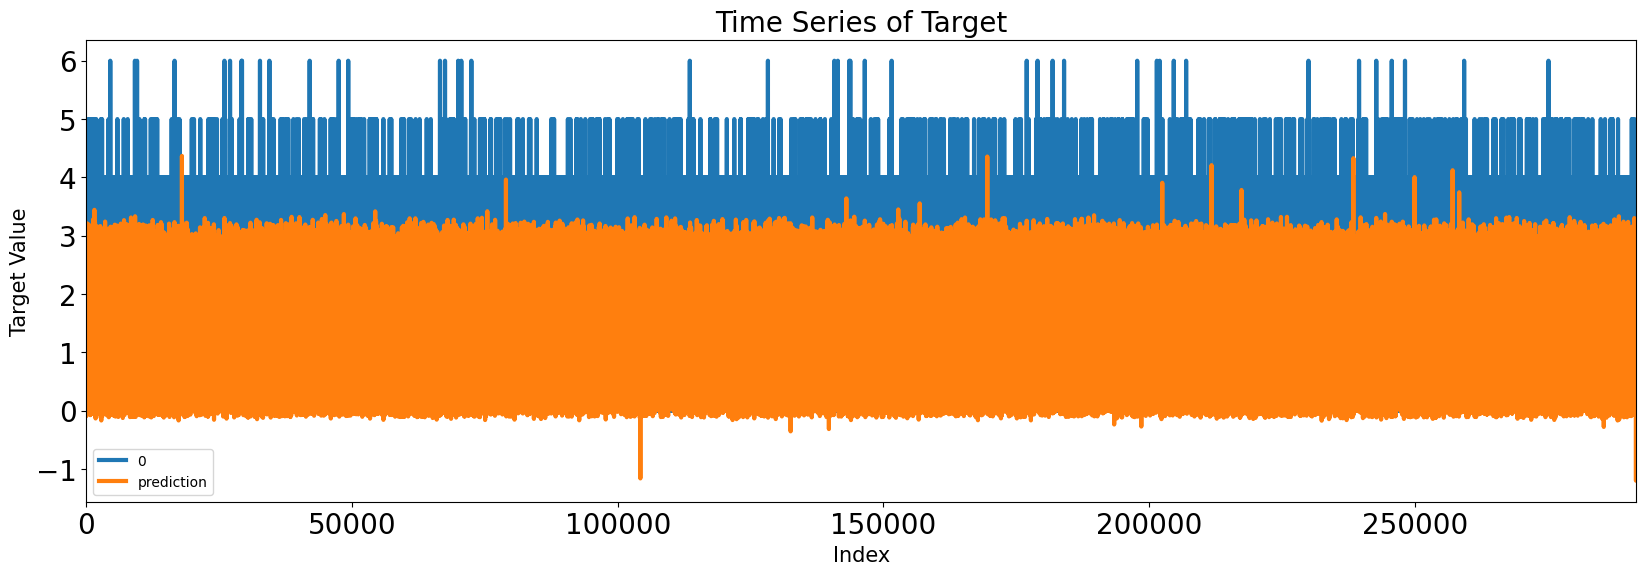

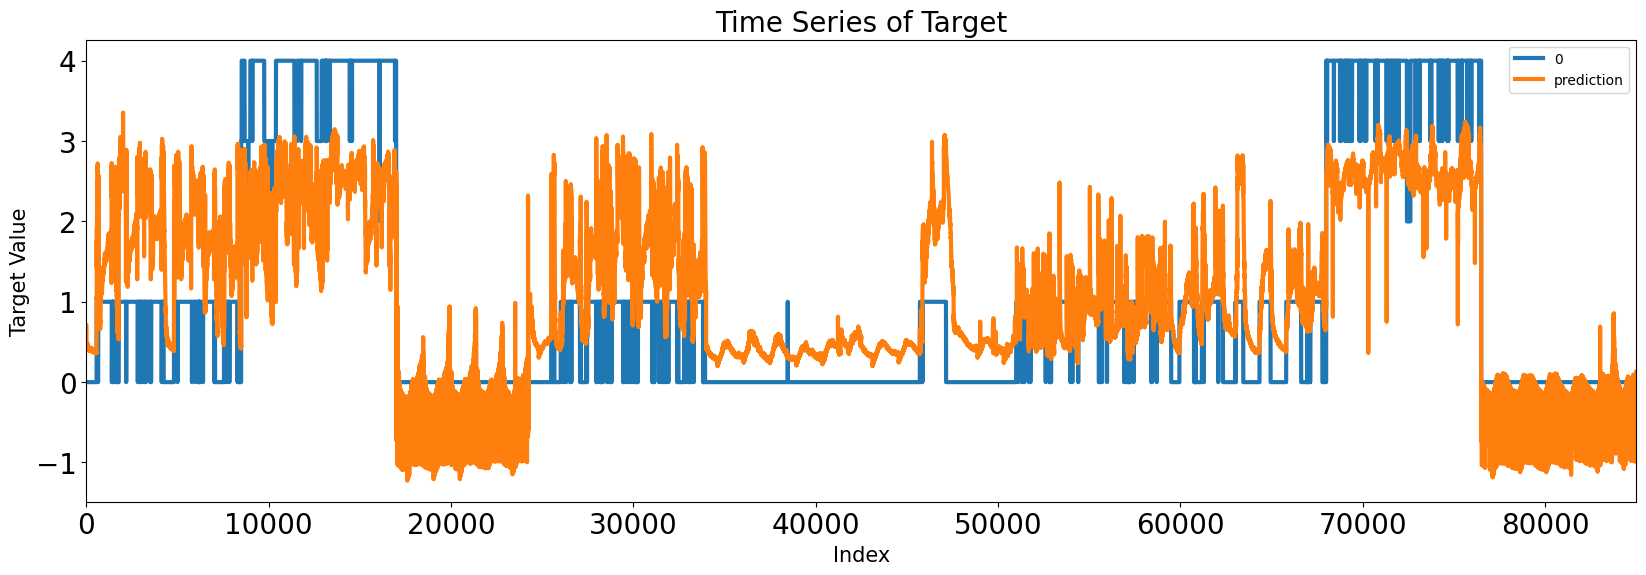

In [55]:
Score_CNN, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(y_train), Y_train_pred.flatten(), pd.DataFrame(y_test), Y_test_pred.flatten(), graph_on=True)

In [56]:
display(Score_CNN)

,MAE,MSE,MAPE
Train,0.700883,0.821094,inf
Test,0.700857,0.794749,inf
